In [18]:
import pandas as pd
import ast
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Set random seed
seed = 0

In [36]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [37]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8763 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               6912 non-null   object 
 13  title                 8784 non-null   object 
 14  video                 8784 non-null   int64  
 15  vote_average         

# Score prediction

In [38]:
df['video'].value_counts()

video
0    8778
1       6
Name: count, dtype: int64

In [39]:
df['cast'] = df['cast'].replace(np.nan, '')
df['directors'] = df['directors'].replace(np.nan, '')
df['genres'] = df['genres'].replace(np.nan, '')
df['title'] = df['title'].replace(np.nan, '')
df['tagline'] = df['tagline'].replace(np.nan, '')
df['overview'] = df['overview'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index])
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index])
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index])
df['production_countries'] = df['production_countries'].replace(np.nan, '')
df['spoken_languages'] = df['spoken_languages'].replace(np.nan, '')

# Split genres into list
df['genres'] = df['genres'].apply(lambda x: [i for i in x.split(',')])
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [i for i in x.split(',')])
df['production_countries'] = df['production_countries'].apply(lambda x: [i for i in x.split(',')])



In [75]:
X = df.drop(columns=['vote_average', 'category'])
X = df.drop(columns=['video', 'adult', 'release_day', 'overview', 'tagline'])
Y = df['category']


In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [42]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                8784 non-null   int64  
 1   genres                8784 non-null   object 
 2   original_language     8784 non-null   object 
 3   overview              8784 non-null   object 
 4   popularity            8784 non-null   float64
 5   production_companies  8784 non-null   object 
 6   production_countries  8784 non-null   object 
 7   revenue               8784 non-null   int64  
 8   runtime               8784 non-null   float64
 9   spoken_languages      8784 non-null   object 
 10  status                8784 non-null   object 
 11  tagline               8784 non-null   object 
 12  title                 8784 non-null   object 
 13  vote_average          8784 non-null   float64
 14  vote_count            8784 non-null   float64
 15  cast                 

In [77]:
print(X.head())

      budget                                             genres  \
0  200000000     [Adventure, Action, Thriller, Science Fiction]   
1  130000000               [Science Fiction, Action, Adventure]   
2  165000000               [Action, Adventure, Science Fiction]   
3  120000000               [Action, Adventure, Science Fiction]   
4   78000000  [Fantasy, Action, Crime, Science Fiction, Thri...   

  original_language  popularity  \
0                en      31.264   
1                en      29.537   
2                en      33.521   
3                en      24.238   
4                en      23.563   

                                production_companies  \
0  [DC Entertainment, De Line Pictures, Warner Br...   
1  [Columbia Pictures, Overbrook Entertainment, S...   
2  [20th Century Fox, TSG Entertainment, Centropo...   
3  [Moving Picture Company, Marvel Entertainment,...   
4  [Marvel Enterprises, New Regency Pictures, Eps...   

                                production_countr

In [78]:
from __future__ import annotations

from typing import Any, Callable, Sequence

import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted


class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. It makes it accept multiple inputs.

    Note that the input `X` has to be a `pandas.DataFrame`.
    """

    def __init__(self, binarizer_creator: Callable[[], Any] | None = None, dtype: npt.DTypeLike | None = None) -> None:
        self.binarizer_creator = binarizer_creator or MultiLabelBinarizer
        self.dtype = dtype

        self.binarizers = []
        self.categories_ = self.classes_ = []
        self.columns = []

    def fit(self, X: pd.DataFrame, y: Any = None) -> MultiHotEncoder:  # noqa
        self.columns = X.columns.to_list()

        for column_name in X:
            binarizer = self.binarizer_creator().fit(X[column_name])
            self.binarizers.append(binarizer)
            self.classes_.append(binarizer.classes_)  # noqa

        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)

        if len(self.classes_) != X.shape[1]:
            raise ValueError(f"The fit transformer deals with {len(self.classes_)} columns "
                             f"while the input has {X.shape[1]}.")

        return np.concatenate([binarizer.transform(X[c]).astype(self.dtype)
                               for c, binarizer in zip(X, self.binarizers)], axis=1)

    def get_feature_names_out(self, input_features: Sequence[str] = None) -> np.ndarray:
        check_is_fitted(self)

        cats = self.categories_

        if input_features is None:
            input_features = self.columns
        elif len(input_features) != len(self.categories_):
            raise ValueError(f"input_features should have length equal to number of features ({len(self.categories_)}),"
                             f" got {len(input_features)}")

        return np.asarray([input_features[i] + "_" + str(t) for i in range(len(cats)) for t in cats[i]])

In [79]:


from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import MultiLabelBinarizer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline', 'title']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into binary (multi-hot) encoding

list_transformer = Pipeline(steps=[
    ('mlb', MultiHotEncoder())  # MultiLabelBinarizer to handle list columns as binary-encoded features
])
# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        # ('bool', boolean_transformer, boolean_features),
        # ('overview', text_transformer, 'overview'),
        # ('tagline', text_transformer, 'tagline'),
        ('list', list_transformer, list_based_features)
    ]
)


# Opaque models

## SVM

In [80]:
clf = svm.SVC(gamma='auto')

# Define your pipeline with preprocessor
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', clf)
])

svm_pipeline.fit(X_train, Y_train_encoded)
Y_pred = svm_pipeline.predict(X_test)

# Convert predicted labels back to original categories
Y_pred_labels = label_encoder.inverse_transform(Y_pred)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Afghanistan', 'Fiji', 'Montenegro', 'Syrian Arab Republic', 'Uganda', 'Venezuela', 'Vietnam'] will be ignored
  warnings.warn(


Accuracy:  0.5133750711439955
Predicted labels: ['bad' 'bad' 'bad' ... 'great' 'bad' 'bad']


In [81]:
# Use randm search to find best hyperparameters
param_dist = {
    'svc__C': uniform(0.1, 10),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': randint(1, 10),
    'svc__gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(svm_pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=seed, verbose=2, n_jobs=-1)
random_search.fit(X_train, Y_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:

[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time= 7.7min
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time= 8.2min
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time= 8.3min
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time= 8.7min
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time= 8.7min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(


[CV] END svc__C=0.6671297731744318, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=12.3min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Congo', 'Iraq', 'Monaco'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bo

[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=17.4min
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=17.5min
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=17.5min
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=17.7min
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=17.7min
[CV] END svc__C=6.558941130666561, svc__degree=5, svc__gamma=auto, svc__kernel=rbf; total time=18.1min
[CV] END svc__C=6.558941130666561, svc__degree=5, svc__gamma=auto, svc__kernel=rbf; total time=18.1min
[CV] END svc__C=6.558941130666561, svc__degree=5, svc__gamma=auto, svc__kernel=rbf; total time=18.1min
[CV] END svc__C=6.558941130666561, svc__degree=5, svc__gamma=auto, svc__kernel=rbf; total time=18.3min
[CV] END svc__C=6.558941130666561, svc__degree=5, svc

/usr/local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END svc__C=0.6671297731744318, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=10.6min
[CV] END svc__C=0.6671297731744318, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=13.2min
[CV] END svc__C=0.6671297731744318, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=12.9min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/pre

[CV] END svc__C=1.5035078041264516, svc__degree=1, svc__gamma=scale, svc__kernel=sigmoid; total time= 5.8min
[CV] END svc__C=8.460787635373775, svc__degree=9, svc__gamma=auto, svc__kernel=linear; total time=10.0min
[CV] END svc__C=8.460787635373775, svc__degree=9, svc__gamma=auto, svc__kernel=linear; total time=10.3min
[CV] END svc__C=8.460787635373775, svc__degree=9, svc__gamma=auto, svc__kernel=linear; total time=10.2min
[CV] END svc__C=8.460787635373775, svc__degree=9, svc__gamma=auto, svc__kernel=linear; total time=10.3min
[CV] END svc__C=8.460787635373775, svc__degree=9, svc__gamma=auto, svc__kernel=linear; total time=10.3min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(


[CV] END svc__C=5.388949197529044, svc__degree=9, svc__gamma=auto, svc__kernel=poly; total time=21.0min
[CV] END svc__C=5.388949197529044, svc__degree=9, svc__gamma=auto, svc__kernel=poly; total time=20.2min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preproc

[CV] END svc__C=1.5035078041264516, svc__degree=1, svc__gamma=scale, svc__kernel=sigmoid; total time=19.7min
[CV] END svc__C=1.5035078041264516, svc__degree=1, svc__gamma=scale, svc__kernel=sigmoid; total time=19.9min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(


[CV] END svc__C=1.5035078041264516, svc__degree=1, svc__gamma=scale, svc__kernel=sigmoid; total time=19.9min
[CV] END svc__C=1.5035078041264516, svc__degree=1, svc__gamma=scale, svc__kernel=sigmoid; total time=19.6min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Congo', 'Iraq', 'Monaco'] will be ignored
  warnings.warn(


[CV] END svc__C=5.388949197529044, svc__degree=9, svc__gamma=auto, svc__kernel=poly; total time=31.4min
[CV] END svc__C=5.388949197529044, svc__degree=9, svc__gamma=auto, svc__kernel=poly; total time=31.5min
[CV] END svc__C=5.388949197529044, svc__degree=9, svc__gamma=auto, svc__kernel=poly; total time=31.7min
[CV] END svc__C=0.30218397440325717, svc__degree=4, svc__gamma=auto, svc__kernel=rbf; total time=32.9min
[CV] END svc__C=0.30218397440325717, svc__degree=4, svc__gamma=auto, svc__kernel=rbf; total time=32.9min
[CV] END svc__C=0.30218397440325717, svc__degree=4, svc__gamma=auto, svc__kernel=rbf; total time=33.3min
[CV] END svc__C=0.30218397440325717, svc__degree=4, svc__gamma=auto, svc__kernel=rbf; total time=33.1min
[CV] END svc__C=0.30218397440325717, svc__degree=4, svc__gamma=auto, svc__kernel=rbf; total time=30.6min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(


[CV] END svc__C=8.091585642167235, svc__degree=4, svc__gamma=auto, svc__kernel=sigmoid; total time=27.4min
[CV] END svc__C=8.091585642167235, svc__degree=4, svc__gamma=auto, svc__kernel=sigmoid; total time=27.1min
[CV] END svc__C=8.091585642167235, svc__degree=4, svc__gamma=auto, svc__kernel=sigmoid; total time=27.2min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(


[CV] END svc__C=4.246619399905235, svc__degree=4, svc__gamma=scale, svc__kernel=sigmoid; total time= 8.2min
[CV] END svc__C=8.091585642167235, svc__degree=4, svc__gamma=auto, svc__kernel=sigmoid; total time=27.8min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Congo', 'Iraq', 'Monaco'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(


[CV] END svc__C=4.246619399905235, svc__degree=4, svc__gamma=scale, svc__kernel=sigmoid; total time= 7.4min
[CV] END svc__C=4.246619399905235, svc__degree=4, svc__gamma=scale, svc__kernel=sigmoid; total time= 7.8min
[CV] END svc__C=8.091585642167235, svc__degree=4, svc__gamma=auto, svc__kernel=sigmoid; total time=16.2min
[CV] END svc__C=4.246619399905235, svc__degree=4, svc__gamma=scale, svc__kernel=sigmoid; total time= 7.4min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Albania', 'Angola', 'Egypt', 'Ethiopia', 'Jordan', 'Kenya', 'Namibia', 'Serbia and Montenegro'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bahamas', 'Belarus', 'Bolivia', 'Botswana', 'Cyprus', 'Pakistan', 'Paraguay', 'Rwanda'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/pre

[CV] END svc__C=6.888795301189603, svc__degree=8, svc__gamma=scale, svc__kernel=poly; total time=19.2min


/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cambodia', 'Dominican Republic', 'Ecuador', 'Kuwait', 'Libyan Arab Jamahiriya', 'Panama', 'Philippines'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bosnia and Herzegovina', 'Cuba', 'Macedonia', 'Malawi', 'Tunisia'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Congo', 'Iraq', 'Monaco'] will be ignored
  warnings.warn(


[CV] END svc__C=4.246619399905235, svc__degree=4, svc__gamma=scale, svc__kernel=sigmoid; total time= 7.3min
[CV] END svc__C=6.888795301189603, svc__degree=8, svc__gamma=scale, svc__kernel=poly; total time=19.9min
[CV] END svc__C=6.888795301189603, svc__degree=8, svc__gamma=scale, svc__kernel=poly; total time=19.6min
[CV] END svc__C=6.888795301189603, svc__degree=8, svc__gamma=scale, svc__kernel=poly; total time=28.8min
[CV] END svc__C=6.888795301189603, svc__degree=8, svc__gamma=scale, svc__kernel=poly; total time=28.5min


In [112]:
# Print best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'svc__C': 0.48425426472734723, 'svc__degree': 5, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


In [113]:
# Predict using best model
Y_pred = random_search.predict(X_test)
Y_pred_labels = label_encoder.inverse_transform(Y_pred)


In [114]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.632896983494593


In [115]:
print(Y_test.value_counts())

category
bad         450
mediocre    448
good        430
great       429
Name: count, dtype: int64


In [116]:
print(Y_train.value_counts())

category
great       1767
good        1766
mediocre    1748
bad         1746
Name: count, dtype: int64


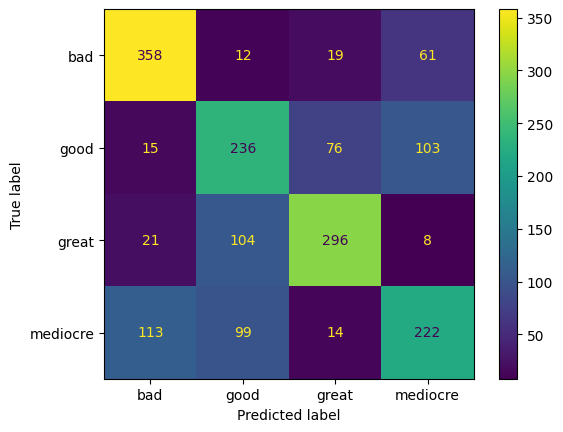

In [119]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()